Загрузки

Dataset

In [ ]:
import os
from itertools import product

import nibabel as nib
import numpy as np
import torch
from skimage.measure import regionprops
from torch.utils.data import DataLoader, Dataset


class FracNetTrainDataset(Dataset):

    def __init__(self, image_dir, label_dir=None, crop_size=32,
            transforms=None, num_samples=4, train=True):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.public_id_list = sorted([x.split("-")[0]
            for x in os.listdir(image_dir)])
        self.crop_size = crop_size
        self.transforms = transforms
        self.num_samples = num_samples
        self.train = train

    def __len__(self):
        return len(self.public_id_list)

    @staticmethod
    def _get_pos_centroids(label_arr):
        centroids = [tuple([round(x) for x in prop.centroid])
            for prop in regionprops(label_arr)]

        return centroids

    @staticmethod
    def _get_symmetric_neg_centroids(pos_centroids, x_size):
        sym_neg_centroids = [(x_size - x, y, z) for x, y, z in pos_centroids]

        return sym_neg_centroids

    @staticmethod
    def _get_spine_neg_centroids(shape, crop_size, num_samples):
        x_min, x_max = shape[0] // 2 - 40, shape[0] // 2 + 40
        y_min, y_max = 300, 400
        z_min, z_max = crop_size // 2, shape[2] - crop_size // 2
        spine_neg_centroids = [(
            np.random.randint(x_min, x_max),
            np.random.randint(y_min, y_max),
            np.random.randint(z_min, z_max)
        ) for _ in range(num_samples)]

        return spine_neg_centroids

    def _get_neg_centroids(self, pos_centroids, image_shape):
        num_pos = len(pos_centroids)
        sym_neg_centroids = self._get_symmetric_neg_centroids(
            pos_centroids, image_shape[0])

        if num_pos < self.num_samples // 2:
            spine_neg_centroids = self._get_spine_neg_centroids(image_shape,
                self.crop_size, self.num_samples - 2 * num_pos)
        else:
            spine_neg_centroids = self._get_spine_neg_centroids(image_shape,
                self.crop_size, num_pos)

        return sym_neg_centroids + spine_neg_centroids

    def _get_roi_centroids(self, label_arr):
        if self.train:
            # generate positive samples' centroids
            pos_centroids = self._get_pos_centroids(label_arr)

            # generate negative samples' centroids
            neg_centroids = self._get_neg_centroids(pos_centroids,
                label_arr.shape)

            # sample positives and negatives when necessary
            num_pos = len(pos_centroids)
            num_neg = len(neg_centroids)
            if num_pos >= self.num_samples:
                num_pos = self.num_samples // 2
                num_neg = self.num_samples // 2
            elif num_pos >= self.num_samples // 2:
                num_neg = self.num_samples - num_pos

            if num_pos < len(pos_centroids):
                pos_centroids = [pos_centroids[i] for i in np.random.choice(
                    range(0, len(pos_centroids)), size=num_pos, replace=False)]
            if num_neg < len(neg_centroids):
                neg_centroids = [neg_centroids[i] for i in np.random.choice(
                    range(0, len(neg_centroids)), size=num_neg, replace=False)]

            roi_centroids = pos_centroids + neg_centroids
        else:
            roi_centroids = [list(range(0, x, y // 2))[1:-1] + [x - y // 2]
                for x, y in zip(label_arr.shape, self.crop_size)]
            roi_centroids = list(product(*roi_centroids))

        roi_centroids = [tuple([int(x) for x in centroid])
            for centroid in roi_centroids]

        return roi_centroids

    def _crop_roi(self, arr, centroid):
        roi = np.ones(tuple([self.crop_size] * 3)) * (-1024)

        src_beg = [max(0, centroid[i] - self.crop_size // 2)
            for i in range(len(centroid))]
        src_end = [min(arr.shape[i], centroid[i] + self.crop_size // 2)
            for i in range(len(centroid))]
        dst_beg = [max(0, self.crop_size // 2 - centroid[i])
            for i in range(len(centroid))]
        dst_end = [min(arr.shape[i] - (centroid[i] - self.crop_size // 2),
            self.crop_size) for i in range(len(centroid))]
        roi[
            dst_beg[0]:dst_end[0],
            dst_beg[1]:dst_end[1],
            dst_beg[2]:dst_end[2],
        ] = arr[
            src_beg[0]:src_end[0],
            src_beg[1]:src_end[1],
            src_beg[2]:src_end[2],
        ]

        return roi

    def _apply_transforms(self, image):
        for t in self.transforms:
            image = t(image)

        return image

    def __getitem__(self, idx):
        # read image and label
        public_id = self.public_id_list[idx]
        image_path = os.path.join(self.image_dir, f"{public_id}-image.nii.gz")
        label_path = os.path.join(self.label_dir, f"{public_id}-label.nii.gz")
        image = nib.load(image_path)
        label = nib.load(label_path)
        image_arr = image.get_fdata().astype(np.float)
        label_arr = label.get_fdata().astype(np.uint8)

        # calculate rois' centroids
        roi_centroids = self._get_roi_centroids(label_arr)

        # crop rois
        image_rois = [self._crop_roi(image_arr, centroid)
            for centroid in roi_centroids]
        label_rois = [self._crop_roi(label_arr, centroid)
            for centroid in roi_centroids]

        if self.transforms is not None:
            image_rois = [self._apply_transforms(image_roi)
                for image_roi in image_rois]

        image_rois = torch.tensor(np.stack(image_rois)[:, np.newaxis],
            dtype=torch.float)
        label_rois = (np.stack(label_rois) > 0).astype(np.float)
        label_rois = torch.tensor(label_rois[:, np.newaxis],
            dtype=torch.float)

        return image_rois, label_rois

    @staticmethod
    def collate_fn(samples):
        image_rois = torch.cat([x[0] for x in samples])
        label_rois = torch.cat([x[1] for x in samples])

        return image_rois, label_rois

    @staticmethod
    def get_dataloader(dataset, batch_size, shuffle=False, num_workers=0):
        return DataLoader(dataset, batch_size, shuffle,
            num_workers=num_workers, collate_fn=FracNetTrainDataset.collate_fn)


class FracNetInferenceDataset(Dataset):

    def __init__(self, image_path, crop_size=32, transforms=None):
        image = nib.load(image_path)
        self.image_affine = image.affine
        self.image = image.get_fdata().astype(np.int16)
        self.crop_size = crop_size
        self.transforms = transforms
        self.centers = self._get_centers()

    def _get_centers(self):
        dim_coords = [list(range(0, dim, self.crop_size // 2))[1:-1]\
            + [dim - self.crop_size // 2] for dim in self.image.shape]
        centers = list(product(*dim_coords))

        return centers

    def __len__(self):
        return len(self.centers)

    def _crop_patch(self, idx):
        center_x, center_y, center_z = self.centers[idx]
        patch = self.image[
            center_x - self.crop_size // 2:center_x + self.crop_size // 2,
            center_y - self.crop_size // 2:center_y + self.crop_size // 2,
            center_z - self.crop_size // 2:center_z + self.crop_size // 2
        ]

        return patch

    def _apply_transforms(self, image):
        for t in self.transforms:
            image = t(image)

        return image

    def __getitem__(self, idx):
        image = self._crop_patch(idx)
        center = self.centers[idx]

        if self.transforms is not None:
            image = self._apply_transforms(image)

        image = torch.tensor(image[np.newaxis], dtype=torch.float)

        return image, center

    @staticmethod
    def _collate_fn(samples):
        images = torch.stack([x[0] for x in samples])
        centers = [x[1] for x in samples]

        return images, centers

    @staticmethod
    def get_dataloader(dataset, batch_size, num_workers=0):
        return DataLoader(dataset, batch_size, num_workers=num_workers,
            collate_fn=FracNetInferenceDataset._collate_fn)

transforms

In [ ]:
import numpy as np


class Window:

    def __init__(self, window_min, window_max):
        self.window_min = window_min
        self.window_max = window_max

    def __call__(self, image):
        image = np.clip(image, self.window_min, self.window_max)

        return image


class MinMaxNorm:

    def __init__(self, low, high):
        self.low = low
        self.high = high

    def __call__(self, image):
        image = (image - self.low) / (self.high - self.low)
        image = image * 2 - 1

        return image

Losses

In [ ]:
from functools import reduce

import torch
import torch.nn as nn
import torch.nn.functional as F


__all__ = ['MixLoss', 'DiceLoss', 'GHMCLoss', 'FocalLoss']


class MixLoss(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.args = args

    def forward(self, x, y):
        lf, lfw = [], []
        for i, v in enumerate(self.args):
            if i % 2 == 0:
                lf.append(v)
            else:
                lfw.append(v)
        mx = sum([w * l(x, y) for l, w in zip(lf, lfw)])
        return mx


class DiceLoss(nn.Module):
    def __init__(self, image=False):
        super().__init__()
        self.image = image

    def forward(self, x, y):
        x = x.sigmoid()
        i, u = [t.flatten(1).sum(1) if self.image else t.sum() for t in [x * y, x + y]]

        dc = (2 * i + 1) / (u + 1)
        dc = 1 - dc.mean()
        return dc


class GHMCLoss(nn.Module):
    def __init__(self, mmt=0, bins=10):
        super().__init__()
        self.mmt = mmt
        self.bins = bins
        self.edges = [x / bins for x in range(bins + 1)]
        self.edges[-1] += 1e-6

        if mmt > 0:
            self.acc_sum = [0] * bins

    def forward(self, x, y):
        w = torch.zeros_like(x)
        g = torch.abs(x.detach().sigmoid() - y)

        n = 0
        t = reduce(lambda x, y: x * y, w.shape)
        for i in range(self.bins):
            ix = (g >= self.edges[i]) & (g < self.edges[i + 1]); nb = ix.sum()
            if nb > 0:
                if self.mmt > 0:
                    self.acc_sum[i] = self.mmt * self.acc_sum[i] + (1 - self.mmt) * nb
                    w[ix] = t / self.acc_sum[i]
                else:
                    w[ix] = t / nb
                n += 1
        if n > 0:
            w = w / n

        gc = F.binary_cross_entropy_with_logits(x, y, w, reduction='sum') / t
        return gc


class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, x, y):
        ce = F.binary_cross_entropy_with_logits(x, y)
        fc = self.alpha * (1 - torch.exp(-ce)) ** self.gamma * ce
        return fc

Architecture

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, first_out_channels=16):
        super().__init__()
        self.first = ConvBlock(in_channels, first_out_channels)
        in_channels = first_out_channels
        self.down1 = Down(in_channels, 2 * in_channels)
        self.down2 = Down(2 * in_channels, 4 * in_channels)
        self.down3 = Down(4 * in_channels, 8 * in_channels)
        self.up1   = Up(8 * in_channels, 4 * in_channels)
        self.up2   = Up(4 * in_channels, 2 * in_channels)
        self.up3   = Up(2 * in_channels, in_channels)
        self.final = nn.Conv3d(in_channels, num_classes, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x1 = self.first(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x  = self.up1(x4, x3)
        x  = self.up2(x, x2)
        x  = self.up3(x, x1)
        x  = self.final(x)
        return x


class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.Conv3d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(inplace=True)
        )


class Down(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            nn.MaxPool3d(2),
            ConvBlock(in_channels, out_channels)
        )


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = nn.Sequential(
            nn.ConvTranspose3d(in_channels, out_channels, 2, stride=2, bias=False),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x, y):
        x = self.conv2(x)
        x = self.conv1(torch.cat([y, x], dim=1))
        return x

metrics

In [ ]:
def dice(x, y, image=False):
    x = x.sigmoid()
    i, u = [t.flatten(1).sum(1) if image else t.sum() for t in [x * y, x + y]]
    dc = ((2 * i + 1) / (u + 1)).mean()
    return dc


def recall(x, y, thresh=0.1):
    x = x.sigmoid()
    tp = (((x * y) > thresh).flatten(1).sum(1) > 0).sum()
    rc = tp / (((y > 0).flatten(1).sum(1) > 0).sum() + 1e-8)
    return rc


def accuracy(x, y, thresh=0.5):
    x = x.sigmoid()
    ac = ((x > thresh) == (y > 0)).float().mean()
    return ac


def precision(x, y, thresh=0.1):
    x = x.sigmoid()
    tp = (((x * y) > thresh).flatten(1).sum(1) > 0).sum()
    pc = tp / (((x > thresh).flatten(1).sum(1) > 0).sum() + 1e-8)
    return pc


def fbeta_score(x, y, beta=1, **kwargs):
    rc = recall(x, y, **kwargs)
    pc = precision(x, y, **kwargs)
    fs = (1 + beta ** 2) * pc * rc / (beta ** 2 * pc + rc + 1e-8)
    return fs

Диск и распаковка

In [ ]:
# RibFrac = zipfile.ZipFile('/content/gdrive/MyDrive/brats_slices_2.zip', 'r')
# RibFrac.extractall('/content')

training

epoch,train_loss,valid_loss,dice,recall,precision,fbeta_score,time
0,1.660285,1.033526,0.133224,0.975610,0.378049,0.533275,06:41
1,1.173136,0.973931,0.277237,0.943089,0.417934,0.567333,08:01
2,0.975365,0.754192,0.319838,0.949477,0.413835,0.564768,07:51
3,0.827413,0.766218,0.344095,0.902439,0.439288,0.573429,07:54
4,0.717965,0.496659,0.550856,0.975610,0.639660,0.762683,07:45
5,0.648817,0.581402,0.484000,0.975610,0.534766,0.671631,07:47
6,0.588012,0.559906,0.519100,0.949477,0.528054,0.673390,07:27
7,0.545700,0.455727,0.591835,0.975610,0.532981,0.672983,07:35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: DeprecationWarning: `np.float` is a deprecated alias f

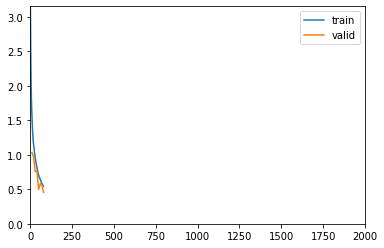

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: DeprecationWarning: `np.float` is a deprecated alias f

epoch,train_loss,valid_loss,dice,recall,precision,fbeta_score,time
0,1.660285,1.033526,0.133224,0.975610,0.378049,0.533275,06:41
1,1.173136,0.973931,0.277237,0.943089,0.417934,0.567333,08:01
2,0.975365,0.754192,0.319838,0.949477,0.413835,0.564768,07:51
3,0.827413,0.766218,0.344095,0.902439,0.439288,0.573429,07:54
4,0.717965,0.496659,0.550856,0.975610,0.639660,0.762683,07:45
5,0.648817,0.581402,0.484000,0.975610,0.534766,0.671631,07:47
6,0.588012,0.559906,0.519100,0.949477,0.528054,0.673390,07:27
7,0.545700,0.455727,0.591835,0.975610,0.532981,0.672983,07:35
8,0.516647,0.526968,0.537542,0.932249,0.766744,0.828678,07:28
9,0.489033,0.547084,0.512169,0.952575,0.567931,0.698741,07:32


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: DeprecationWarning: `np.float` is a deprecated alias f

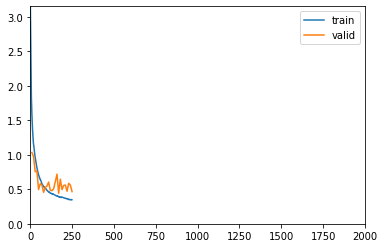

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: DeprecationWarning: `np.float` is a deprecated alias f

In [ ]:
from functools import partial

from torch import save

from fastai.basic_train import Learner
from fastai.train import ShowGraph
from fastai.data_block import DataBunch
from torch import optim

# from dataset.fracnet_dataset import FracNetTrainDataset
# from dataset import transforms as tsfm
# from utils.metrics import dice, recall, precision, fbeta_score
# from model.unet import UNet
# from model.losses import MixLoss, DiceLoss


def main():
    train_image_dir = '/content/drive/MyDrive/shorttrain-images'
    train_label_dir = '/content/drive/MyDrive/shorttrain-labels'
    val_image_dir = '/content/drive/MyDrive/shortval-images'
    val_label_dir = '/content/drive/MyDrive/shortval-labels'

    batch_size = 4
    num_workers = 2
    optimizer = optim.SGD
    criterion = MixLoss(nn.BCEWithLogitsLoss(), 0.5, DiceLoss(), 1)

    thresh = 0.1
    recall_partial = partial(recall, thresh=thresh)
    precision_partial = partial(precision, thresh=thresh)
    fbeta_score_partial = partial(fbeta_score, thresh=thresh)

    model = UNet(1, 1, first_out_channels=16)
    model = nn.DataParallel(model.cuda())

    transforms = [
        Window(-200, 1000), #-200, 1000
        MinMaxNorm(-200, 1000)
    ]
    ds_train = FracNetTrainDataset(train_image_dir, train_label_dir,
        transforms=transforms)
    dl_train = FracNetTrainDataset.get_dataloader(ds_train, batch_size, False,
        num_workers)
    ds_val = FracNetTrainDataset(val_image_dir, val_label_dir,
        transforms=transforms)
    dl_val = FracNetTrainDataset.get_dataloader(ds_val, batch_size, False,
        num_workers)

    databunch = DataBunch(dl_train, dl_val,
        collate_fn=FracNetTrainDataset.collate_fn)

    learn = Learner(
        databunch,
        model,
        opt_func=optimizer,
        loss_func=criterion,
        metrics=[dice, recall_partial, precision_partial, fbeta_score_partial]
    )

    learn.fit_one_cycle(
        200,
        1e-1,
        pct_start=0,
        div_factor=1000,
        callbacks=[
            ShowGraph(learn),
        ]
    )

    # if args.save_model:
    #     save(model.module.state_dict(), "./model_weights.pth")


# if __name__ == "__main__":
#     import argparse


#     parser = argparse.ArgumentParser()
#     parser.add_argument("--train_image_dir", required=True,
#         help="The training image nii directory.")
#     parser.add_argument("--train_label_dir", required=True,
#         help="The training label nii directory.")
#     parser.add_argument("--val_image_dir", required=True,
#         help="The validation image nii directory.")
#     parser.add_argument("--val_label_dir", required=True,
#         help="The validation label nii directory.")
#     parser.add_argument("--save_model", default=False,
#         help="Whether to save the trained model.")
#     args = parser.parse_args()

main()